# Tanvi's ANN results
## Prep

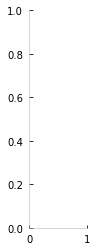

In [1]:
# HIDE CELL
from importlib import reload

import matplotlib.pylab as plt
import numpy as np

import deps
reload(deps)

alldat, dat_LFP, dat_ST = deps.get_data()
dat = alldat[0]
sp, neu, trial_starts = deps.convert_raster_to_spiketimes(dat)
events_df = deps.convert_events_to_dataframe(dat, trial_starts,
                                             event_names=('gocue', 'response_time','feedback_time'),
                                             condition_names=('response','contrast_right','contrast_left','feedback_type'))

spykes_times = deps.spykes_get_times(sp, neu)

dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high

## Encode stimulus onset into spike trains using a Poisson GLM

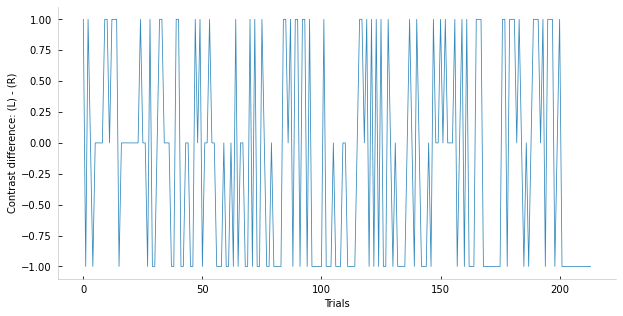

95


In [2]:
#Make contrast matrix
cL = dat['contrast_left']; cR = dat['contrast_right']
cdiff = np.empty_like(cL)

for i in range(len(cL)):
    cdiff[i] = 1*(cL[i]>cR[i]) + (-1)*(cL[i] < cR[i]) + 0*(cL[i] == cR[i])

f=plt.figure(figsize=(10,5))
plt.plot(cdiff); plt.xlabel('Trials'); plt.ylabel('Contrast difference: (L) - (R)'); plt.show()
print(np.sum(cdiff<0))

In [3]:
# Dependencies
import pdb
from scipy.optimize import minimize
def make_design_matrix(stim,d):
    try:
        padded_stim = np.concatenate([np.zeros(d - 1), stim])
    except:
        print('Fuck')
        pdb.set_trace()
    T = len(stim)  # Total number of timepoints (hint: total number of stimulus frames)
    X = np.zeros((T, d))
    for t in range(T):
        X[t] = padded_stim[t:t+d]

    return X
    
def neg_log_like(theta,X,y,L1_penalty):
#      Args:
#     theta (1D array): Parameter vector.
#     X (2D array): Full design matrix.
#     y (1D array): Data values. Number of spikes for each trial
    
    rate = np.exp(X @ theta)
    penalty = 20*np.sum((theta)**2) #20*np.sum(np.abs(theta))
    LL = y @ np.log(rate) - np.ones_like(y) @ rate
    log_lik = LL - penalty
#     print(f' LL: {LL:1.3f}, L1: {penalty:1.3f}, log_lik: {log_lik:1.3f}')
    return -log_lik

def fit_lnp(stim,dummy,spikes,d,L1_penalty):
    y = spikes
    constant = np.ones_like(y)
    
#     pdb.set_trace()
    X = np.column_stack([constant, dummy, make_design_matrix(stim,d)])

    # Use a random vector of weights to start (mean 0, sd .2)
    theta0 = np.random.normal(0, .2, np.size(X[0]))  #d + 1)

    # Find parameters that minmize the negative log likelihood function
    res = minimize(neg_log_like, theta0, args=(X, y,L1_penalty))

    return res["x"]

def predict_spike_counts_lnp(stim,dummy,spikes,d,L1_penalty,theta=None):
    y = spikes
    constant = np.ones_like(spikes)

    if theta is None:
        theta = fit_lnp(stim,dummy,y,d,L1_penalty)
    
    #Make X again to compute predicted spikes
    X = np.column_stack([constant, dummy, make_design_matrix(stim,d)])
    yhat = np.exp(X @ theta)
    return yhat, theta



(214, 734)
OG indices of neurons with min 5 spikes
[363 369 419 422 432 437 453 474 485 490 506 516 531 538 548 610 618 631
 633 650 651 652 656 662 669 670 673 675 687 688 694 696 697 698]


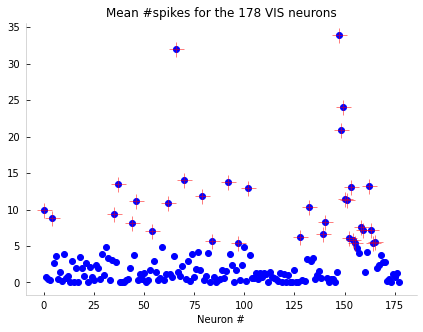

In [4]:
all_spikes = np.transpose(np.sum(dat['spks'][:,:,50:131],axis=2)); print(all_spikes.shape)

#Visualize vis-ctx neurons' firing rates
idx_vis = np.char.startswith(dat['brain_area'],'VIS',start=0,end=None)
vis_neurons = np.where(idx_vis)[0]

#Find neurons with high-ish spike rates and try to encode
vis_spikes = all_spikes[:,vis_neurons] #print(vis_spikes.shape)
f = plt.figure(figsize=(7,5))
mean_vis_spikes = np.mean(vis_spikes,axis=0)
plt.plot(mean_vis_spikes,'ob'); plt.title(f'Mean #spikes for the {len(vis_neurons):d} VIS neurons')
plt.xlabel('Neuron #')

#Pick neurons with a threshold firing rate/spike number
spike_thresh = 5
idx_high = np.where(mean_vis_spikes>spike_thresh)[0]
vis_neurons_thresh = vis_neurons[idx_high]

print(f'OG indices of neurons with min {spike_thresh:d} spikes'); print(vis_neurons_thresh) # to keep track of which original neuron
plt.plot(idx_high, mean_vis_spikes[idx_high],'+r',markersize=15,alpha=0.5)

# plt.savefig('Figures/Choice of neuron.png')

In [5]:
'''
1. Divide data into train-test. Preserve chronology!
2. Encode 
    (a) contrast difference, 
    (b) right contrast in Poisson GLM on train data
3. Test accuracy on test data.
    (a) MSE
    (b) R^2

'''
# Initialise variables for Poisson GLM fitting
L1_penalty = 1

# Define types of stimuli
stim_type =['Contrast difference','Left contrast','Right contrast']

# Get index of train and test data
idx_train = range(0,int(len(cdiff)*0.75)); idx_test = range(int(len(cdiff)*0.75), len(cdiff))

# Divide stimuli into train and test 
stim_train = np.empty(shape=(len(idx_train),len(stim_type)))
stim_test = np.empty(shape=(len(idx_test),len(stim_type)))

stim_train[:,0] = cdiff[idx_train]; stim_test[:,0] = cdiff[idx_test] # Stimulus 1: Contrast difference
stim_train[:,1] = cL[idx_train]; stim_test[:,1] = cL[idx_test]  # Stimulus 2: Right contrast
stim_train[:,2] = cR[idx_train]; stim_test[:,2] = cR[idx_test]  # Stimulus 2: Right contrast
dummy_train = abs(dat['response'][idx_train])>0

# Divide spikes into train and test
spikes_train = all_spikes[idx_train,:]; spikes_train = spikes_train[:, vis_neurons_thresh]
spikes_test = all_spikes[idx_test,:]; spikes_test = spikes_test[:, vis_neurons_thresh]
dummy_test = abs(dat['response'][idx_test])>0



In [6]:
#!pip install torch
import torch
from torch import nn
from torch import optim

In [7]:
'''
Fit spike/trial with ANN models

First write this separately, then combine together
'''

# Define an Artificial Neural Network with 1 layer 
class DeepNetReLU(nn.Module):
    def __init__(self, n_inputs, n_hidden,n_output):
        super().__init__()  # needed to invoke the properties of the parent class nn.Module
        self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
        self.out_layer = nn.Linear(n_hidden, n_output) # hidden units --> output

    def forward(self, r):
#         h = torch.softmax(self.in_layer(r),dim=1)
#         y = torch.LongTensor(self.out_layer(h))
        y = torch.exp(self.in_layer(r),dim=1) # One layer ANN should be equivalent to GLM
        return y

# Train the ANN
def train(net,loss_fn,train_data,train_labels,n_iter,learning_rate):
    # Initialize optimizer with SGD
    optimizer = optim.SGD(net.parameters(),lr=learning_rate)
    
    track_loss = np.empty(shape=(n_iter,1)) # Accumulate loss function here
    for i in range(n_iter):
        # Run NN to calculate output and loss
        out = net(train_data)
        loss = loss_fn(out,train_labels)
        
        print('here 1')
    
        # Computer gradient
        optimizer.zero_grad()
        loss.backward()
        print('here 2')
        
        # Update weights
        optimizer.step()
        print('here 3')
        
        # Record loss at this iteration
        track_loss[i] = loss.item()
        print(f'Iteration {i}, loss: {track_loss[i]}')
        # Track progress:
        
#         if (i+1) % (n_iter//5) == 0 :
#             print(f'Iteration: {(i+1):d}/{n_iter:d}: Loss: {track_loss[i]:.4f}')
            
    return track_loss
       

In [8]:
# Make X (delayed stimulus sequence) and Y (spike) to feed into the ANN

np.random.seed(1)
torch.manual_seed(1)
loss_fn=nn.MSELoss()

chosen_neuron = 1
d=10
X = torch.tensor(make_design_matrix(stim_train[:,2],d), dtype=torch.float64)
Y = torch.tensor(spikes_train[:,chosen_neuron], dtype=torch.float64)

net=DeepNetReLU(d,1,1)



In [9]:
train_loss=train(net,loss_fn,X,Y,n_iter=5,learning_rate=1e-3)
f=plt.figure(figsize=(7,5))
plt.plot(train_loss)
plt.show()

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'mat1' in call to _th_addmm

In [ ]:
# Test code on Stringer training data from Tutorial W3D4 
# Checked: results match
import pickle
data = open('resp_stimuli_train.dat', 'rb')
dd = pickle.load(data)
# print(dd[1].shape)



In [ ]:
np.random.seed(1)
torch.manual_seed(1)

loss_fn=nn.MSELoss()

net=DeepNetReLU(23589,20,1)
resp_train=dd[0]; stimuli_train=dd[1]
out = net(resp_train); ll=loss_fn(out,stimuli_train)

print(type(resp_train))
# train_loss = train(net, loss_fn, resp_train, stimuli_train,50,1e-4)
# plt.plot(train_loss); plt.ylabel('Training loss'); plt.xlabel('Iteration #')
# plt.show()

In [ ]:
torch.tensor(X)

In [ ]:
# np.random.seed(1)
# torch.manual_seed(1)

# loss_fn=nn.MSELoss()

# net=DeepNetReLU(23589,20,1)

# resp_train=dd[0]; stimuli_train=dd[1]; print(stimuli_train.shape)
train_loss = train(net, loss_fn, resp_train, stimuli_train,50,1e-4)
plt.plot(train_loss)

In [ ]:
np.sqrt(5)

